In [ ]:
!pip install datasets

# **1. LIBRARIES**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
from google.colab import drive
from datasets import load_dataset
import nltk

# **2. DATA PREPROCESSING**

In [ ]:
dataset = load_dataset('financial_phrasebank', 'sentences_allagree')
df = pd.DataFrame(dataset["train"])
df

,sentence,label
0,"According to Gran , the company has no plans t...",1
1,"For the last quarter of 2010 , Componenta 's n...",2
2,"In the third quarter of 2010 , net sales incre...",2
3,Operating profit rose to EUR 13.1 mn from EUR ...,2
4,"Operating profit totalled EUR 21.1 mn , up fro...",2
...,...,...
2259,Operating result for the 12-month period decre...,0
2260,HELSINKI Thomson Financial - Shares in Cargote...,0
2261,LONDON MarketWatch -- Share prices ended lower...,0
2262,Operating profit fell to EUR 35.4 mn from EUR ...,0


**NOTE:** Dataset `financial_phrasebank` memiliki 3 kelas dan berasal dari HuggingFace yang dikhususkan untuk *sentiment analysis*.

## **2.1 Text Normalization**

In [ ]:
drive.mount("/content/drive")

# Load slang dictionary
slangs_df = pd.read_csv("/content/drive/MyDrive/slangs.csv")
slangs_df.drop(columns="Unnamed: 0", inplace=True)
slang_dict = dict(zip(slangs_df['Abbr'], slangs_df['Fullform']))

def normalize_slang_text(text, slang):
    words = text.split()
    normalized_words = [slang.get(word, word) for word in words]
    return ' '.join(normalized_words)

# List of currency-related words to remove
currency_words = {'eur', 'EUR', 'mn', 'MN'}

def remove_currency_words(words_list):
    return [word for word in words_list if word not in currency_words]

def normalize_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    words = text.split()
    # Normalize slang
    normalized_slang_words = normalize_slang_text(' '.join(words), slang_dict)
    # Remove currency related words
    words_no_currency = remove_currency_words(normalized_slang_words.split())
    return ' '.join(words_no_currency)

# Apply normalization to each sentence
df["normalized_sentence"] = df['sentence'].apply(normalize_text)

# Display the updated DataFrame
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,sentence,label,normalized_sentence
0,"According to Gran , the company has no plans t...",1,according to gran the company has no plans to ...
1,"For the last quarter of 2010 , Componenta 's n...",2,for the last quarter of componenta s net sales...
2,"In the third quarter of 2010 , net sales incre...",2,in the third quarter of net sales increased by...
3,Operating profit rose to EUR 13.1 mn from EUR ...,2,operating profit rose to from in the correspon...
4,"Operating profit totalled EUR 21.1 mn , up fro...",2,operating profit totalled up from in represent...
...,...,...,...
2259,Operating result for the 12-month period decre...,0,operating result for the month period decrease...
2260,HELSINKI Thomson Financial - Shares in Cargote...,0,helsinki thomson financial shares in cargotec ...
2261,LONDON MarketWatch -- Share prices ended lower...,0,london marketwatch share prices ended lower in...
2262,Operating profit fell to EUR 35.4 mn from EUR ...,0,operating profit fell to from in including ves...


In [ ]:
# One-hot encoding for labels
category = pd.get_dummies(df["label"])
df = pd.concat([df, category], axis=1)
df.drop(columns="label", inplace=True)
df

,sentence,normalized_sentence,0,1,2
0,"According to Gran , the company has no plans t...",according to gran the company has no plans to ...,0,1,0
1,"For the last quarter of 2010 , Componenta 's n...",for the last quarter of componenta s net sales...,0,0,1
2,"In the third quarter of 2010 , net sales incre...",in the third quarter of net sales increased by...,0,0,1
3,Operating profit rose to EUR 13.1 mn from EUR ...,operating profit rose to from in the correspon...,0,0,1
4,"Operating profit totalled EUR 21.1 mn , up fro...",operating profit totalled up from in represent...,0,0,1
...,...,...,...,...,...
2259,Operating result for the 12-month period decre...,operating result for the month period decrease...,1,0,0
2260,HELSINKI Thomson Financial - Shares in Cargote...,helsinki thomson financial shares in cargotec ...,1,0,0
2261,LONDON MarketWatch -- Share prices ended lower...,london marketwatch share prices ended lower in...,1,0,0
2262,Operating profit fell to EUR 35.4 mn from EUR ...,operating profit fell to from in including ves...,1,0,0


In [ ]:
text = df['normalized_sentence'].values
label = df[[0, 1, 2]].values
label

array([[0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)

## **2.2 Data Splitting**

In [ ]:
# Splitting data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(text, label, test_size=0.2, random_state=42)

print(f'X_train Shape: {X_train.shape}')
print(f'X_val Shape: {X_val.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'y_val Shape: {y_val.shape}')

X_train Shape: (1811,)
X_val Shape: (453,)
y_train Shape: (1811, 3)
y_val Shape: (453, 3)


## **2.3 Text Tokenization**

In [ ]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

vocab_size = len(tokenizer.word_index) + 1

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Padding sequences
max_length = max([len(x) for x in X_train_seq])
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post')

# **3. DATA MODELLING**

## **3.1 Data Training with GloVe Word Embeddings**

In [ ]:
# Load GloVe embeddings
embeddings_index = {}
with open('/content/drive/MyDrive/glove.6B.300d.txt', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create embedding matrix
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 300))  # 300 adalah dimensi GloVe
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Create LSTM model with GloVe embedding matrix
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 300, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(LSTM(128, dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Callbacks
class CustomEarlyStopping(Callback):
    def __init__(self, target_accuracy=0.90):
        super(CustomEarlyStopping, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        if train_acc is not None and val_acc is not None:
            if train_acc >= self.target_accuracy and val_acc >= self.target_accuracy:
                print(f'\nMenghentikan pelatihan karena training accuracy dan validation accuracy telah mencapai {self.target_accuracy*100}%')
                self.model.stop_training = True

# Instance from CustomEarlyStopping
custom_early_stopping = CustomEarlyStopping(target_accuracy=0.93)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Training the model
history = model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=100, batch_size=32, callbacks=[custom_early_stopping, reduce_lr])

# Evaluate the model
accuracy = model.evaluate(X_val_pad, y_val)[1]
print(f'Validation Accuracy: {accuracy*100:.2f}%')

Epoch 1/100
57/57 [==============================] - 3s 15ms/step - loss: 0.7784 - accuracy: 0.6842 - val_loss: 0.6084 - val_accuracy: 0.7572 - lr: 0.0010
Epoch 2/100
57/57 [==============================] - 0s 6ms/step - loss: 0.5855 - accuracy: 0.7642 - val_loss: 0.5536 - val_accuracy: 0.7726 - lr: 0.0010
Epoch 3/100
57/57 [==============================] - 0s 6ms/step - loss: 0.5307 - accuracy: 0.7692 - val_loss: 0.5348 - val_accuracy: 0.7815 - lr: 0.0010
Epoch 4/100
57/57 [==============================] - 0s 6ms/step - loss: 0.4684 - accuracy: 0.7858 - val_loss: 0.4575 - val_accuracy: 0.8079 - lr: 0.0010
Epoch 5/100
57/57 [==============================] - 0s 6ms/step - loss: 0.4416 - accuracy: 0.7885 - val_loss: 0.5567 - val_accuracy: 0.8057 - lr: 0.0010
Epoch 6/100
57/57 [==============================] - 0s 5ms/step - loss: 0.4603 - accuracy: 0.8056 - val_loss: 0.4791 - val_accuracy: 0.8057 - lr: 0.0010
Epoch 7/100
57/57 [==============================] - 0s 5ms/step - loss: 0.

## **3.2 Model Evaluation**

In [ ]:
# Make predictions
y_pred = model.predict(X_val_pad)

# Convert predicted labels and validation labels into class format
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Classification report
report = classification_report(y_val_classes, y_pred_classes, target_names=['Class 0 (negative)', 'Class 1 (neutral)', 'Class 2 (positive)'])

print(report)

15/15 [==============================] - 0s 3ms/step
                    precision    recall  f1-score   support

Class 0 (negative)       0.94      0.82      0.88        56
 Class 1 (neutral)       0.96      0.97      0.96       276
Class 2 (positive)       0.87      0.90      0.89       121

          accuracy                           0.93       453
         macro avg       0.92      0.90      0.91       453
      weighted avg       0.93      0.93      0.93       453



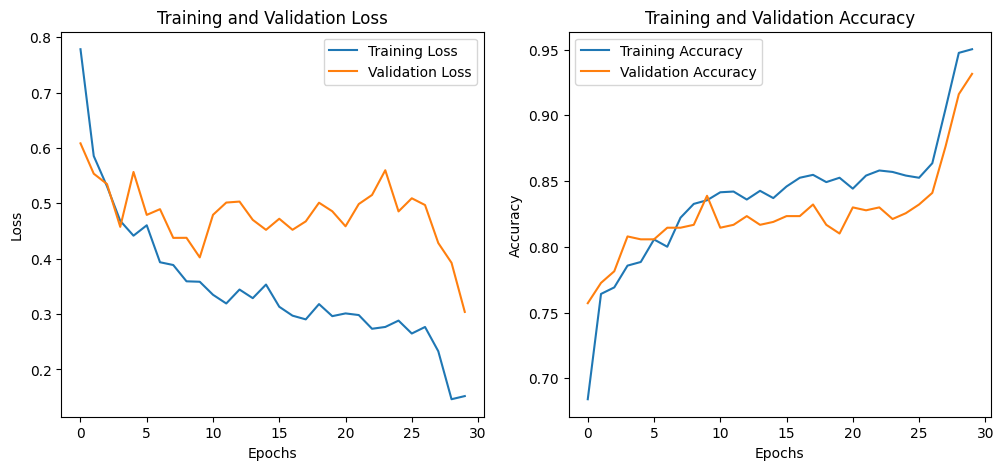

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()